# Assignment 4
Nathan Jester

This is a copy of the assignment text for quick reference:

Assignment 4 (100pt)
- Use heart_disease_uci.csv to answer the questions below. 
- You may refer to the code from previous self-learning days to help you get started. 
- Please present your analysis results in a clear and well-formatted table. All key features, tables, and answers should be included in this document. 
- The code you use and your ChatGPT conversation log should be submitted as separate files.
- Q1. Show the histogram of Heart_Disease_Stage. What potential issues can you identify based on the distribution ?
- Q2. 
    - a.	Identify the best decision tree (DT) that predicts Heart_Disease_Stage. 
    - b.	Describe how you reach the final DT. Show necessary steps (e.g., training error vs. testing error) and the results of your model.
    - c.	Perform oversampling technique(s) and report the difference in predictive performance.
    - d.	Discuss possible concerns from the perspective of bias and variance.
- Q3. Find the best performing RandomForest, AdaBoost, and Gradient Boosting models. Describe your steps for the search, and report the key parameters use, and the results of these three best performing model. 
- Q4. 
    - a.	Use Lasso Regression to perform feature selection. 
    - b.	Then, use multiclass-logistic regression and predict the Heart_Disease_Stage with the selected features. Next, compare the performance with the best performing model you find in #Q3. 
    - c.	Multiclass-logistic regression is most likely to receive lower performance than the best performing model from #Q3. Discuss what might be the reasons?
- Q5. Use the same parameter you used for best performing model in #Q3, and run XGboost and compare the predictive performance with the best performing model in #Q3. Note that XGboost uses both L1 and L2 regularization. Discuss why you may see such differences in the performance from the perspective of bias and variance. Notion of regularization and brief explanation of L1 and L2 should be included to gain full points. 

## Load the Data

In [46]:
import pandas as pd

In [47]:
file_name = "heart_disease_uci2-1.csv"
df = pd.read_csv(file_name)
df.rename({'num': 'Heart_Disease_Stage'}, axis=1, inplace=True)
print("Shape:", df.shape)
df.head()

Shape: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,Heart_Disease_Stage
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [48]:
missing_vals = df.isnull().sum().sort_values(ascending=False)
missing_vals

ca                     611
thal                   486
slope                  309
fbs                     90
oldpeak                 62
trestbps                59
exang                   55
thalch                  55
chol                    30
restecg                  2
cp                       0
dataset                  0
id                       0
age                      0
sex                      0
Heart_Disease_Stage      0
dtype: int64

In [49]:
import numpy as np

# Fill numerical columns with their median
numerical_cols = df.select_dtypes(include=[np.number]).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Fill categorical columns with the most frequent value (mode)
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Data Cleaning
df.drop('id', axis=1, inplace=True, errors="ignore")  # Drop ID column

# Categorical variables to be one-hot encoded
categorical_cols = ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
#, 'Heart_Disease_Stage'
# One-hot encoding using get_dummies
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False).astype(int)

# Replace spaces in all column names with underscores
df_encoded.columns = df_encoded.columns.str.replace(' ', '_')

df_encoded.head()

C:\Users\natha\AppData\Local\Temp\ipykernel_19916\3453979577.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])


,age,trestbps,chol,thalch,oldpeak,ca,Heart_Disease_Stage,sex_Female,sex_Male,dataset_Cleveland,...,restecg_normal,restecg_st-t_abnormality,exang_False,exang_True,slope_downsloping,slope_flat,slope_upsloping,thal_fixed_defect,thal_normal,thal_reversable_defect
0,63,145,233,150,2,0,0,0,1,1,...,0,0,1,0,1,0,0,1,0,0
1,67,160,286,108,1,3,2,0,1,1,...,0,0,0,1,0,1,0,0,1,0
2,67,120,229,129,2,2,1,0,1,1,...,0,0,0,1,0,1,0,0,0,1
3,37,130,250,187,3,0,0,0,1,1,...,1,0,1,0,1,0,0,0,1,0
4,41,130,204,172,1,0,0,1,0,1,...,0,0,1,0,0,0,1,0,1,0


Standardize numerical variables (Features)

In [50]:
# Define numerical variables to standardize
from sklearn.discriminant_analysis import StandardScaler


numerical_vars = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

# Initialize StandardScaler
scaler = StandardScaler()
# Apply scaling only to the selected numerical columns
df_encoded[numerical_vars] = scaler.fit_transform(df_encoded[numerical_vars])

# Print the first few rows to verify the standardization
print(df_encoded[numerical_vars].head())

        age  trestbps      chol    thalch   oldpeak        ca
0  1.007386  0.705176  0.303643  0.489727  1.326348 -0.361400
1  1.432034  1.518569  0.789967 -1.181478  0.323686  4.411152
2  1.432034 -0.650479  0.266939 -0.345875  1.326348  2.820301
3 -1.752828 -0.108217  0.459634  1.961979  2.329010 -0.361400
4 -1.328180 -0.108217  0.037541  1.365120  0.323686 -0.361400


## Q1.
Show the histogram of Heart_Disease_Stage. What potential issues can you identify based on the distribution ?

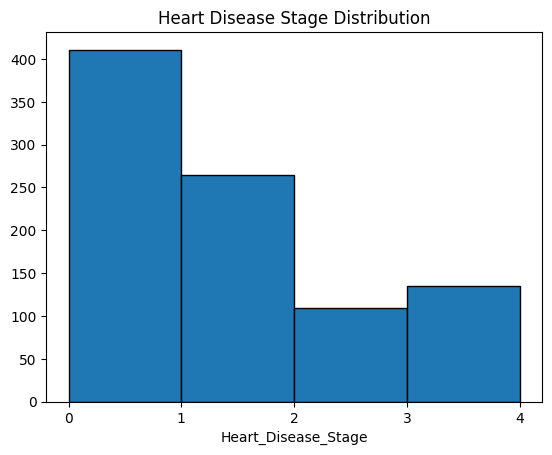

In [82]:
from matplotlib import pyplot as plt

bins = df_encoded.Heart_Disease_Stage.sort_values().unique()
plt.hist(df_encoded.Heart_Disease_Stage, bins=bins, edgecolor='black')
plt.title("Heart Disease Stage Distribution")
plt.xticks(bins)
plt.xlabel("Heart_Disease_Stage")
plt.show()

#### Analysis:
The classes are not balanced.  The fact that the predicted classes are not balanced can bias some classification algorithms, such as decision trees.

## Q2.

### a.
Identify the best decision tree (DT) that predicts Heart_Disease_Stage. 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


# partition the data
X = df_encoded.drop(columns=['Heart_Disease_Stage'])
y = df_encoded.Heart_Disease_Stage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# build a model (depth 5 selected via trial and error)
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)

# test the model (I'll just use accuracy for now)
y_pred = model.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[99 13  2  6  0]
 [25 40  9  4  0]
 [ 5  8 12  9  0]
 [ 9  9 11  6  1]
 [ 0  2  3  3  0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.82      0.77       120
           1       0.56      0.51      0.53        78
           2       0.32      0.35      0.34        34
           3       0.21      0.17      0.19        36
           4       0.00      0.00      0.00         8

    accuracy                           0.57       276
   macro avg       0.36      0.37      0.37       276
weighted avg       0.54      0.57      0.55       276



#### Analysis
I started by plotting iterating over depths of 1, 3, 5, 7, 9, and 11 and found that 5 seemed to perform the best with lower scores never predicting some of the less common classes and assuming that higher values were overfitting.

### b.
Describe how you reach the final DT. Show necessary steps (e.g., training error vs. testing error) and the results of your model.

### c.
Perform oversampling technique(s) and report the difference in predictive performance.

It appears that we want 411 samples of each class

In [109]:
# get oversampled X
num_samples = 500
_dfs = []
for stage, stage_df in df_encoded.groupby('Heart_Disease_Stage'):
    _df = stage_df.sample(num_samples, replace=True, random_state=42)
    _dfs.append(_df)
df_oversample = pd.concat(_dfs)
print("Oversample Shape", df_oversample.shape)
df_oversample.head()

Oversample Shape (2500, 30)


,age,trestbps,chol,thalch,oldpeak,ca,Heart_Disease_Stage,sex_Female,sex_Male,dataset_Cleveland,...,restecg_normal,restecg_st-t_abnormality,exang_False,exang_True,slope_downsloping,slope_flat,slope_upsloping,thal_fixed_defect,thal_normal,thal_reversable_defect
185,1.007386,0.434045,-0.045042,1.643654,-0.678977,2.820301,0,1,0,1,...,1,0,1,0,0,0,1,0,1,0
487,0.795061,-0.108217,0.863374,-0.703991,0.323686,-0.361400,0,1,0,0,...,0,1,0,1,0,1,0,0,1,0
409,-0.478883,0.434045,-0.118449,1.365120,-0.678977,-0.361400,0,0,1,0,...,1,0,1,0,0,1,0,0,1,0
196,1.644358,1.518569,0.312819,-0.266294,-0.678977,1.229451,0,0,1,1,...,0,0,1,0,0,1,0,0,1,0
131,-0.266559,-2.060360,0.248588,0.648889,-0.678977,1.229451,0,0,1,1,...,1,0,0,1,0,0,1,0,0,1


In [121]:
# partition the data
X = df_oversample.drop(columns=['Heart_Disease_Stage'])
y = df_oversample.Heart_Disease_Stage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# build a model (depth 5 selected via trial and error)
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)

# test the model (I'll just use accuracy for now)
y_pred = model.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[123  17  16   0   2]
 [ 26  56  46   4   6]
 [ 15   5  98   6  30]
 [ 15   3  68  45  34]
 [  7   0  35   0  93]]

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.78      0.72       158
           1       0.69      0.41      0.51       138
           2       0.37      0.64      0.47       154
           3       0.82      0.27      0.41       165
           4       0.56      0.69      0.62       135

    accuracy                           0.55       750
   macro avg       0.62      0.56      0.55       750
weighted avg       0.62      0.55      0.54       750



### d.
Discuss possible concerns from the perspective of bias and variance.

## Q3.
Find the best performing RandomForest, AdaBoost, and Gradient Boosting models. Describe your steps for the search, and report the key parameters use, and the results of these three best performing model. 


In [125]:
# partition the data
X = df_oversample.drop(columns=['Heart_Disease_Stage'])
y = df_oversample.Heart_Disease_Stage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [126]:
from sklearn.ensemble import RandomForestClassifier


# build a model (depth 5 selected via trial and error)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# test the model (I'll just use accuracy for now)
y_pred = model.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[151   6   0   1   0]
 [  8 118   8   4   0]
 [  0   0 154   0   0]
 [  0   0   5 160   0]
 [  0   0   0   0 135]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       158
           1       0.95      0.86      0.90       138
           2       0.92      1.00      0.96       154
           3       0.97      0.97      0.97       165
           4       1.00      1.00      1.00       135

    accuracy                           0.96       750
   macro avg       0.96      0.96      0.96       750
weighted avg       0.96      0.96      0.96       750



In [128]:
from sklearn.ensemble import AdaBoostClassifier


# build a model (depth 5 selected via trial and error)
model = AdaBoostClassifier(random_state=42)
model.fit(X_train, y_train)

# test the model (I'll just use accuracy for now)
y_pred = model.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[69 67 15  4  3]
 [12 74 27  8 17]
 [ 2 35 53 23 41]
 [ 6 21 45 33 60]
 [ 0 18 21 17 79]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.44      0.56       158
           1       0.34      0.54      0.42       138
           2       0.33      0.34      0.34       154
           3       0.39      0.20      0.26       165
           4       0.40      0.59      0.47       135

    accuracy                           0.41       750
   macro avg       0.45      0.42      0.41       750
weighted avg       0.45      0.41      0.41       750



In [129]:
from sklearn.ensemble import GradientBoostingClassifier


# build a model (depth 5 selected via trial and error)
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

# test the model (I'll just use accuracy for now)
y_pred = model.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[137  10   6   4   1]
 [ 18  95  17   7   1]
 [  0   2 146   6   0]
 [  4   7  14 140   0]
 [  0   0   0   0 135]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.86       158
           1       0.83      0.69      0.75       138
           2       0.80      0.95      0.87       154
           3       0.89      0.85      0.87       165
           4       0.99      1.00      0.99       135

    accuracy                           0.87       750
   macro avg       0.87      0.87      0.87       750
weighted avg       0.87      0.87      0.87       750



## Q4

### a.
Use Lasso Regression to perform feature selection. 


In [ ]:
from sklearn.linear_model import Lasso


# build a model (depth 5 selected via trial and error)
model = Lasso(random_state=42)
model.fit(X_train, y_train)
model.coef_

array([ 0.,  0., -0., -0.,  0.,  0., -0.,  0.,  0., -0.,  0.,  0.,  0.,
       -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,  0.,  0., -0., -0.,
        0., -0.,  0.])

### b.
Then, use multiclass-logistic regression and predict the Heart_Disease_Stage with the selected features. Next, compare the performance with the best performing model you find in #Q3. 

In [138]:
from sklearn.linear_model import LogisticRegression


# build a model (depth 5 selected via trial and error)
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# test the model (I'll just use accuracy for now)
y_pred = model.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[122  19   4   3  10]
 [ 24  64  19  19  12]
 [  7  10  73  41  23]
 [  7  15  39  52  52]
 [  0   6  30  24  75]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.77      0.77       158
           1       0.56      0.46      0.51       138
           2       0.44      0.47      0.46       154
           3       0.37      0.32      0.34       165
           4       0.44      0.56      0.49       135

    accuracy                           0.51       750
   macro avg       0.52      0.52      0.51       750
weighted avg       0.52      0.51      0.51       750



c:\Users\natha\Documents\Classes\MST\MLA\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Q5.
Use the same parameter you used for best performing model in #Q3, and run XGboost and compare the predictive performance with the best performing model in #Q3. Note that XGboost uses both L1 and L2 regularization. Discuss why you may see such differences in the performance from the perspective of bias and variance. Notion of regularization and brief explanation of L1 and L2 should be included to gain full points. 

In [ ]:
from xgboost import XGBClassifier


# build a model
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# test the model (I'll just use accuracy for now)
y_pred = model.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[150   4   2   2   0]
 [ 11 117   7   3   0]
 [  0   0 154   0   0]
 [  0   2   4 159   0]
 [  0   0   0   0 135]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       158
           1       0.95      0.85      0.90       138
           2       0.92      1.00      0.96       154
           3       0.97      0.96      0.97       165
           4       1.00      1.00      1.00       135

    accuracy                           0.95       750
   macro avg       0.95      0.95      0.95       750
weighted avg       0.95      0.95      0.95       750



: 